# P3 Udacity CarND Behavioral Cloning Project

Submitted by Florian Wulff

## General

The goal of this project is to train a Deep Neural Network, such as the NVIDIA End-to-End Learning Network [here](https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf) or the CommaAi architecture [here](https://github.com/commaai/research/blob/master/train_steering_model.py).

The training of these architectures is based on the used data set. The quality and fit of the used dataset is crutial for the success and generalisation of the DNN.

This project is based on the data set provided by Udacity. Thanks to Udacity, the provided dataset is well suited to train those architecture without additional data.

![simulator](./images/simulator.png)

## Dataset exploration

The dataset needs to be well balanced and equalized to teach how to drive straight, but also how to drive curves and how to recover.

### dataset_exploration.py

The code in dataset_exploration serves to analyze the data.

A histogram of the steering angles recorded in the dataset is created to analyze its distribution.
Also the description of the data is printed using Pandas.

          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


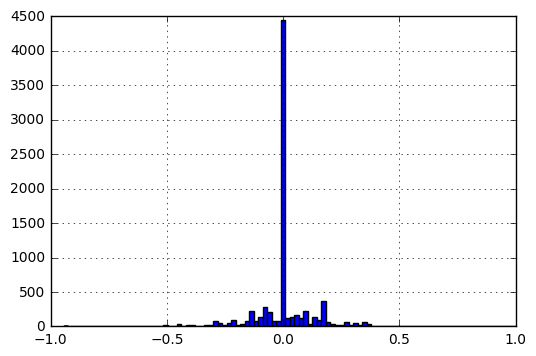

In [7]:
%matplotlib inline

import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.exposure import adjust_gamma
from scipy.misc import imresize

# read original file
data = pd.read_csv('./data/data/driving_log.csv')
    
# create histogram of steering angles
histogram = data.steering.hist(bins=100)
histogram.plot()
print(data.describe())

It can be seen, that the data is consisting of 8036 examples, each including a left, center and right images, as well as steering, throttle, brake and speed entries.

The architecture will be used to predict only the steering angle, while throttle is fixed and the car is never braking.

The steering angle:
* ranges from -0.94 to 1.0 values, thus representing the extrema
* a steering angle of 0.0000 is most common, in fact overrepresented
* this bias would lead the car to drive straight in any situation to minimize the loss while training.
* also 25%, 50% and 75% percent values are all 0.0000
* the mean is nearly 0.
* values larger than 0.5 or smaller than -0.5 are very rare, thus can be seen as outlier causing oversteering

## dataset augmentation

Next, the dataset will be equalized to be suitable for the training.

* Deleting a certain amound of 0.0 values (0-100%)
* Deleting outliers >0.5 and <-0.5

Number of entries deleted:  3269
          steering     throttle        brake        speed
count  4723.000000  4723.000000  4723.000000  4723.000000
mean      0.007561     0.890120     0.002476    28.635165
std       0.155662     0.270763     0.044372     5.219810
min      -0.496498     0.000000     0.000000     0.512715
25%      -0.069252     0.985533     0.000000    30.181875
50%       0.000000     0.985533     0.000000    30.185970
75%       0.090465     0.985533     0.000000    30.186610
max       0.492344     0.985533     1.000000    30.709360


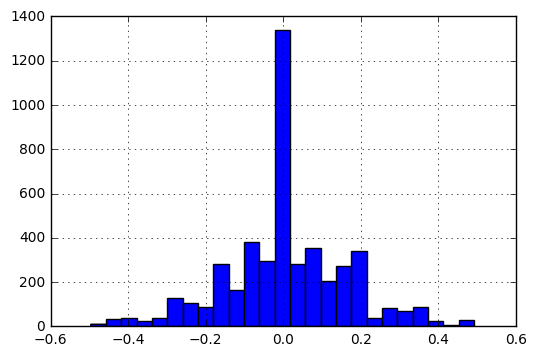

In [8]:
index_array = []
# delete steering angles of 0. to reduce bias towards straight driving
delete_prob = 75

for index in range(len(data)):
    if (data.steering[index] == 0.):
        rand_prob = np.random.randint(0,100)
        if rand_prob < delete_prob:
            index_array.append(index)
    
data = data.drop(index_array)
    
# delete all entries with 0. angle
# data = data[data.steering != 0.]

print("Number of entries deleted: ", len(index_array))

delete_outliers = True

if delete_outliers == True:
    # delete steering angles of >0.5 or <-0.5 to reduce oversteering
    data = data[data.steering < 0.5]
    data = data[data.steering > -0.5]
    
# create histogram of steering angles
histogram_new = data.steering.hist(bins=25)
histogram_new.plot()
print(data.describe())
    
# write to new file
# data.to_csv('./data/data/driving_log_new.csv')

After equalizing the dataset:
* the steering is much smoother distributed
* the data is now roughly gaussian shaped
* ranges from -0.5 to 0.5 values, thus representing no extreme steering
* a steering angle of 0.0000 is still most common to avoid curvy behavior
* the deviation of values is much larger
* 25%, 50% and 75% percent values changed to represent steering and straight driving
* the mean is still nearly 0.

In [ ]:
##


## generator.py

The generator.py contains all preprocessing functions for the images, data augmentation as well as a generator for training and validation data.

### Data preprocessing

The preprocessing consists of the following in process image:

* Use of YUV colorspace (eventually use only Y-channel)
* Resize of the images to a smaller format to speed training and reduce memory usage
* cropping of upper and lower parts of the image, which contain no road information
* Lightning equalization against shadows and illumination using adjust_gamma

The data preprocessing will also be applied to the input stream images during simulation.

### Data augmentation

* To teach the model how to drive left as well as right turns, the images get randomly (by 50%) mirrored, as well as the angle.
* The generator chooses left, center and right images using given probabilities, such as 0.2, 0.4, 0.4 etc. Usually all camera images would be equal, but this way, a bias towards recovery and curves or straight driving can be artifically created. This is necessary to improve the behavior in curvy parts.
* If left or right images are choosen, a correction factor has to be applied to the angle to simulate the offset. Based on experience and other students suggestions, a value of .1 to .3 seems suitable. I ended up using 0.15

Additional augmentation could be 

* random rotation to account for wrong car orientation
* random shear to account to for recovery situations outside the lane center

No further augmentation was implemented, as the data was suitable for training without.

### Generators

The project uses python generators to create the training and validation data. This prevents an OOM error, which would occur using large dataset at once.

The generator yield a batch of training or validation data, depending on the batch size.

* The generator uses the given batch_size = 64 to create a list of 64 image names and angles, which are randomly choosen. 
* The generator applies the image processing and image augmentation
* The loaded images and angle batches are return to the training and validation using _yield_
* The train data generator and validation data generator can use different probabilites for the camera position, as the simulation will be only center images

A different approach would be using Keras _datagen = ImageDataGenerator_ and _datagen.fit(X_train)_ or layers inside the DNN for real time image processing, augmentation and batch generation. While this is suitable for image classification etc, here it will fail, because it can not adjust the steering angle with respect to the image modification. This results in wrong labels and no ability to drive.

## model.py

The model.py is used for the model architecture and training.

* the _balance dataset()_ is applied
* The image format used is defined
* Training parameters, such as epochs, nb of samples per epoch and learning rate is defined
* Two different architectures, the CommaAI model and a model based on the NVIDIA paper is defined. 
* Loss function is MSE 
* Optimizer is Adam with the custom learning rate 
* Previously stored models and weights will be removed, if present
* The model is saved to model.json
* The train data generator and validation data generator are initialized
* The training uses checkpoints to save all intermediate progress, if improved
* Callbacks are used to use an _early stopping_. This will end the training, if more than 3 epochs are not improving the model. This reduce overfitting and shortens training, as usually very few epochs are necessary.
* Finally the weights are stored in model.h5

## Training

The architecture choosen is based heavily on the NVIDIA model but using different image sizes and different sizes of layers.
```
Layer (type)                     Output Shape          Param #     Connected to                     
====================================================================================================
batchnormalization_2 (BatchNormal(None, 60, 80, 3)     120         batchnormalization_input_2[0][0] 
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 29, 39, 24)    672         batchnormalization_2[0][0]       
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 27, 19, 36)    7812        convolution2d_6[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 25, 17, 48)    15600       convolution2d_7[0][0]            
____________________________________________________________________________________________________
convolution2d_9 (Convolution2D)  (None, 24, 16, 64)    12352       convolution2d_8[0][0]            
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 23, 15, 64)    16448       convolution2d_9[0][0]            
____________________________________________________________________________________________________
flatten_2 (Flatten)              (None, 22080)         0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 100)           2208100     flatten_2[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 100)           0           dense_4[0][0]                    
____________________________________________________________________________________________________
activation_3 (Activation)        (None, 100)           0           dropout_2[0][0]                  
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 10)            1010        activation_3[0][0]               
____________________________________________________________________________________________________
activation_4 (Activation)        (None, 10)            0           dense_5[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 1)             11          activation_4[0][0]               
====================================================================================================
Total params: 2262125
____________________________________________________________________________________________________
model saved as model.json
```

* 5 Convolutional layers are followed by 3 Dense Fully connected layers.
* Dropout is used to reduce overfitting.
* The total number is very large due to the fully connected layers.

The model was trained:

* using very small image of 60x80x3 and cropping 15 px at the top and 5px at the bottom
* using a very low learning rate of 0.0001
* using early termination and checkpoints
* using only 3 to 8 epochs approx.

```
model saved as model.json
Epoch 1/3
20032/20048 [============================>.] - ETA: 0s - loss: 0.0196  
Epoch 00000: val_loss improved from inf to 0.01036, saving model to model.h5
20096/20048 [==============================] - 270s - loss: 0.0195 - val_loss: 0.0104
Epoch 2/3
20032/20048 [============================>.] - ETA: 0s - loss: 0.0131  Epoch 00001: val_loss did not improve
20096/20048 [==============================] - 165s - loss: 0.0131 - val_loss: 0.0106
Epoch 3/3
20032/20048 [============================>.] - ETA: 0s - loss: 0.0125  Epoch 00002: val_loss did not improve
Epoch 00002: early stopping
20096/20048 [==============================] - 195s - loss: 0.0125 - val_loss: 0.0104
Training completed
weights stored as model.h5
```

## Evaluation

The model is run using the udacity simulator in autonomous mode and _drive.py_ with:

`python drive.py model.json`

drive.py loads the sockets and the model with its weights. It is important to apply the preprocessing used while training to the image stream as well!

The NVIDIA model is able to drive itself sucessfully:

* the simulator is run on lowest resolution and graphics quality simple
* a throttle of 0.2 is used
* the track 1 can be done for endless rounds
* it struggles a little bit with the bridge section due to missing lane markings
* can keep the middle of the road with lane markings very well
* a video file of two rounds is uploaded as well

![simulator_start](./images/simulator_start.png)

![evaluation](./images/autonom.png)